# Aprendizagem Automática Avançada - Assignment 6
# Cláudia Afonso nº 36273 & Rita Rodrigues nº 54859

## Problem 2

**Implement an autoencoder to learn to encode images from the dataset given in the image classification tutorial, based on the reference model used in the previous exercise.**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import PIL
import pathlib

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization

**a) Train an autoencoder on 3500 images from the image classification dataset, leaving 170 aside for validation.**

In [2]:
# Download the dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)


# Load the dataset 
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.0465,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.0465,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 3500 files for training.
Found 3670 files belonging to 5 classes.
Using 170 files for validation.


In [3]:
normalization_layer = layers.Rescaling(1./255)

In [4]:
# Standardising the data

normalized_train = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val = val_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [5]:
train_x = np.concatenate([x for x,y in normalized_train], axis=0)
val_x = np.concatenate([x for x,y in normalized_val], axis=0)

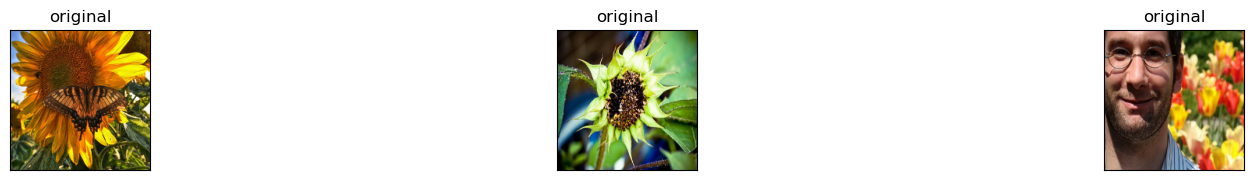

In [6]:
n = 3
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original (training set)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_x[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

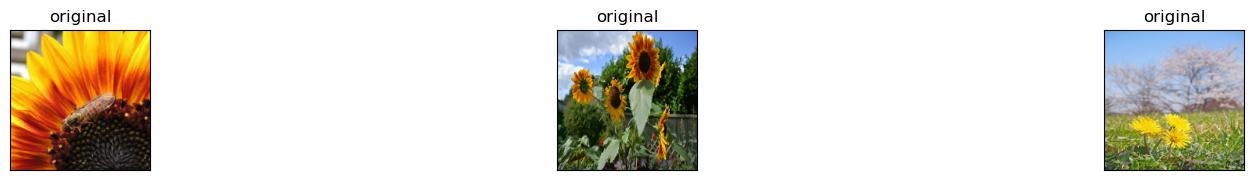

In [7]:
n = 3
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original (validation set)
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(val_x[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [8]:
# Adapting reference model from Problem 1 (with a dropout probability of 20%)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(2025),
  layers.Reshape((45,45, 1)),
  layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
  layers.BatchNormalization(),
  layers.Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same'),
  layers.BatchNormalization(),
  layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
])

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(
              name='mean_squared_error'),
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [11]:
latent_dim = 90

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Conv2D(16, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(32, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Conv2D(64, 3, padding='same', activation='relu'),
          layers.MaxPooling2D(),
          layers.Dropout(0.2),
          layers.Flatten(),
          layers.Dense(90, activation='relu'),
          layers.BatchNormalization()
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(2025),
          layers.Reshape((45,45, 1)),
          layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same'),
          layers.BatchNormalization(),
          layers.Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same'),
          layers.BatchNormalization(),
          layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [12]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [13]:
autoencoder.fit(train_x, train_x,
                epochs=5,
                shuffle=True,
                validation_data=(val_x, val_x))

Epoch 1/5
110/110 [==============================] - 135s 1s/step - loss: 0.0654 - val_loss: 0.0807
Epoch 2/5
110/110 [==============================] - 132s 1s/step - loss: 0.0439 - val_loss: 0.0787
Epoch 3/5
110/110 [==============================] - 132s 1s/step - loss: 0.0411 - val_loss: 0.0698
Epoch 4/5
110/110 [==============================] - 131s 1s/step - loss: 0.0392 - val_loss: 0.0568
Epoch 5/5
110/110 [==============================] - 134s 1s/step - loss: 0.0380 - val_loss: 0.0453


Training of the model was only performed with 5 epochs due to technical limitations of our computers and the inability to use Colab.

**b) Sample 3 examples from each dataset split, the train and validation set, and use the autoencoder to encode and decode the images, comparing them with the original.**

In [14]:
train_examples = train_x[:3]
val_examples = val_x[:3]

In [15]:
# Reconstructing the examples from the train and validation sets

reconstruction_train = autoencoder.predict(train_examples)
reconstruction_val = autoencoder.predict(val_examples)

1/1 [==============================] - 0s 48ms/step


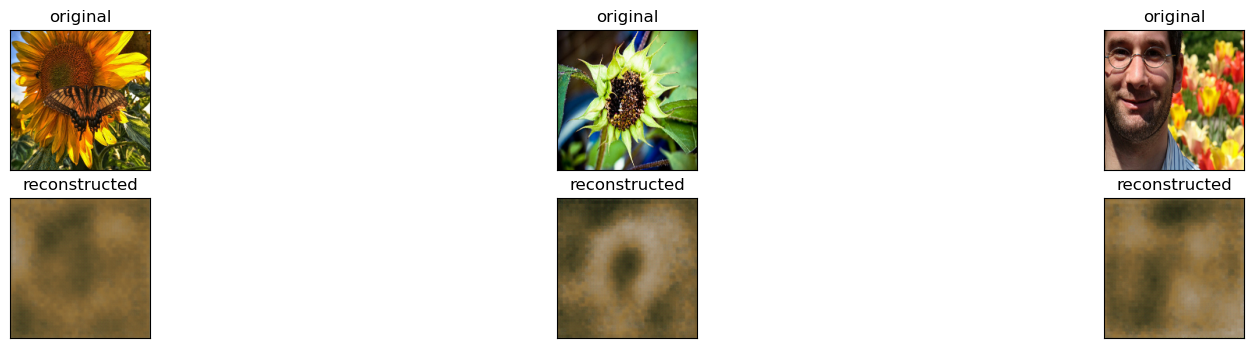

In [16]:
# Plotting the original and reconstructed examples from the train set

plt.figure(figsize=(20, 4))
for i in range(3):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_examples[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruction_train[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

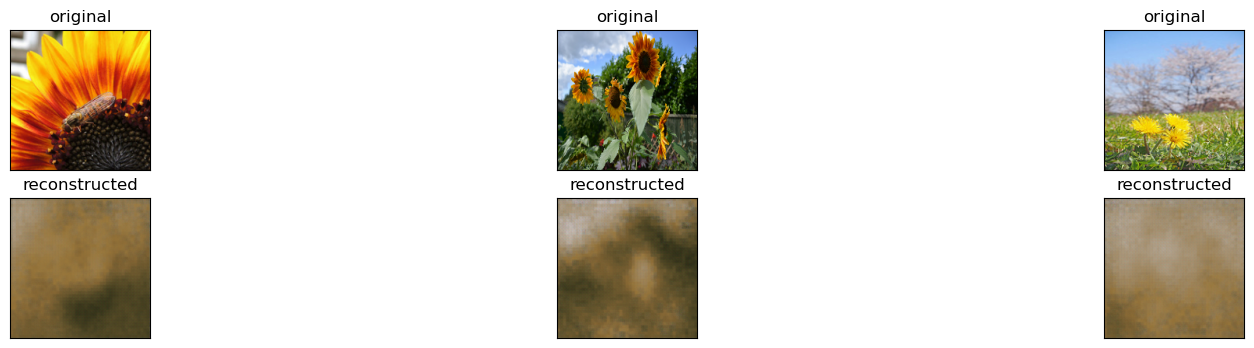

In [17]:
# Plotting the original and reconstructed examples from the validation set

plt.figure(figsize=(20, 4))
for i in range(3):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(val_examples[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruction_val[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The reconstructed images from the training and validation examples are quite dark, likely due to the low amount of epochs chosen for the training of the autoencoder. In a previous attempt using Colab, a higher number of epochs was chosen and the images were significantly brighter and more defined.

**c) Sample 3 examples from each dataset split, the train and validation set, encoding the images using the Encoder, obtaining the intermediate representations. Using the GaussianNoise layer, introduce 5%, 10% and 20% noise to the representations. Finally, decode the representations using the Decoder and analyze the obtained images**

In [18]:
from keras.layers import GaussianNoise

In [19]:
encoded_train_examples = autoencoder.encoder.predict(train_examples)

encoded_val_examples = autoencoder.encoder.predict(val_examples)

1/1 [==============================] - 0s 32ms/step


Introducing 5% noise to the intermediate representations

In [20]:
# Introducing 5% noise to the intermediate representations in the training examples

encoded_train_noisy_5 = encoded_train_examples + 0.05 * tf.random.normal(encoded_train_examples.shape)
encoded_train_noisy_5 = tf.clip_by_value(encoded_train_noisy_5, clip_value_min=0., clip_value_max=1.)

# Introducing 5% noise to the intermediate representations in the validation examples

encoded_val_noisy_5 = encoded_val_examples + 0.05 * tf.random.normal(encoded_val_examples.shape)
encoded_val_noisy_5 = tf.clip_by_value(encoded_val_noisy_5, clip_value_min=0., clip_value_max=1.)

In [21]:
# Decoding the training examples after introducing 5% noise to the intermediate representations

decoded_train_noisy_5 = autoencoder.decoder.predict(encoded_train_noisy_5)

1/1 [==============================] - 0s 157ms/step


In [22]:
# Decoding the validation examples after introducing 5% noise to the intermediate representations

decoded_val_noisy_5 = autoencoder.decoder.predict(encoded_val_noisy_5)

1/1 [==============================] - 0s 63ms/step


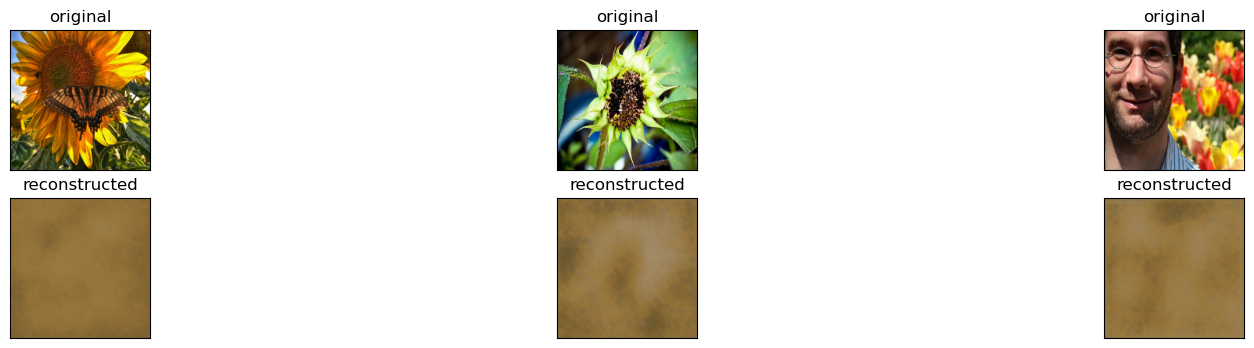

In [23]:
# Comparing the original and decoded examples from the train set 
# after introducing 5% noise to the intermediate representations

plt.figure(figsize=(20, 4))
for i in range(3):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_examples[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_train_noisy_5[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

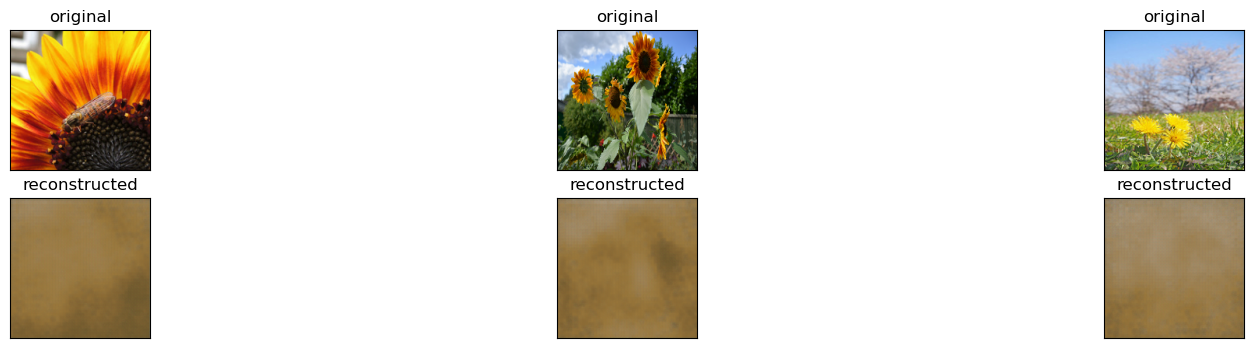

In [24]:
# Comparing the original and decoded examples from the validation set 
# after introducing 5% noise to the intermediate representations

plt.figure(figsize=(20, 4))
for i in range(3):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(val_examples[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_val_noisy_5[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Introducing 10% noise to the intermediate representations

In [25]:
# Introducing 10% noise to the intermediate representations in the training examples

encoded_train_noisy_10 = encoded_train_examples + 0.10 * tf.random.normal(encoded_train_examples.shape)
encoded_train_noisy_10 = tf.clip_by_value(encoded_train_noisy_10, clip_value_min=0., clip_value_max=1.)

# Introducing 10% noise to the intermediate representations in the validation examples

encoded_val_noisy_10 = encoded_val_examples + 0.10 * tf.random.normal(encoded_val_examples.shape)
encoded_val_noisy_10 = tf.clip_by_value(encoded_val_noisy_10, clip_value_min=0., clip_value_max=1.)

In [26]:
# Decoding the training examples after introducing 10% noise to the intermediate representations

decoded_train_noisy_10 = autoencoder.decoder.predict(encoded_train_noisy_10)

1/1 [==============================] - 0s 47ms/step


In [27]:
# Decoding the validation examples after introducing 10% noise to the intermediate representations

decoded_val_noisy_10 = autoencoder.decoder.predict(encoded_val_noisy_10)

1/1 [==============================] - 0s 63ms/step


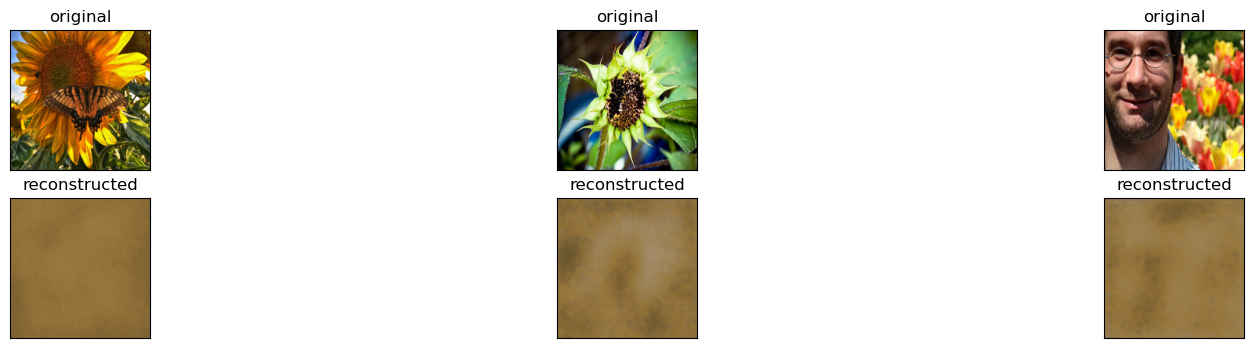

In [28]:
# Comparing the original and decoded examples from the train set 
# after introducing 10% noise to the intermediate representations

plt.figure(figsize=(20, 4))
for i in range(3):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_examples[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_train_noisy_10[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

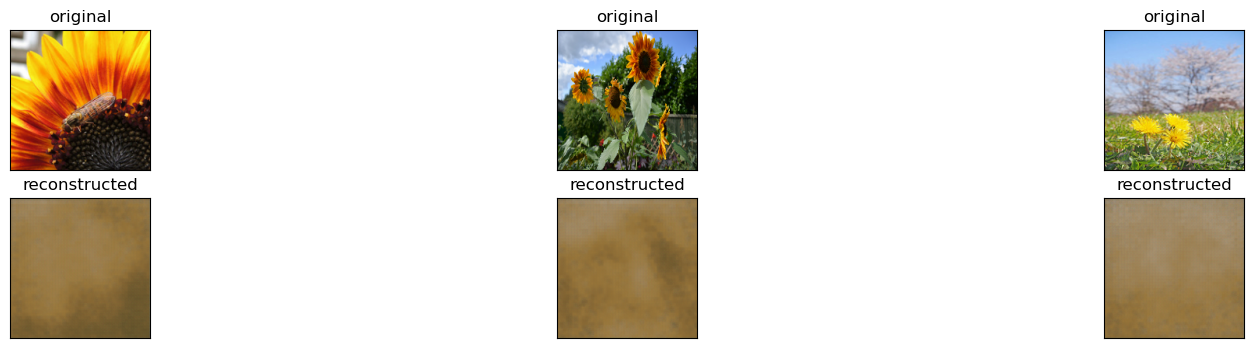

In [29]:
# Comparing the original and decoded examples from the validation set 
# after introducing 10% noise to the intermediate representations

plt.figure(figsize=(20, 4))
for i in range(3):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(val_examples[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_val_noisy_10[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Introducing 20% noise to the intermediate representations

In [30]:
# Introducing 20% noise to the intermediate representations in the training examples

encoded_train_noisy_20 = encoded_train_examples + 0.20 * tf.random.normal(encoded_train_examples.shape)
encoded_train_noisy_20 = tf.clip_by_value(encoded_train_noisy_20, clip_value_min=0., clip_value_max=1.)

# Introducing 20% noise to the intermediate representations in the validation examples

encoded_val_noisy_20 = encoded_val_examples + 0.20 * tf.random.normal(encoded_val_examples.shape)
encoded_val_noisy_20 = tf.clip_by_value(encoded_val_noisy_20, clip_value_min=0., clip_value_max=1.)

In [31]:
# Decoding the training examples after introducing 20% noise to the intermediate representations

decoded_train_noisy_20 = autoencoder.decoder.predict(encoded_train_noisy_20)

1/1 [==============================] - 0s 47ms/step


In [32]:
# Decoding the validation examples after introducing 20% noise to the intermediate representations

decoded_val_noisy_20 = autoencoder.decoder.predict(encoded_val_noisy_20)

1/1 [==============================] - 0s 54ms/step


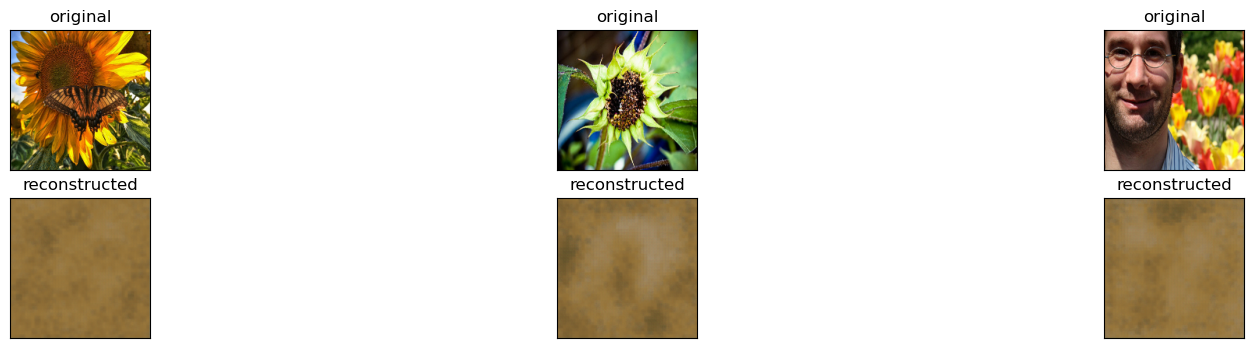

In [33]:
# Comparing the original and decoded examples from the train set 
# after introducing 20% noise to the intermediate representations

plt.figure(figsize=(20, 4))
for i in range(3):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_examples[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_train_noisy_20[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

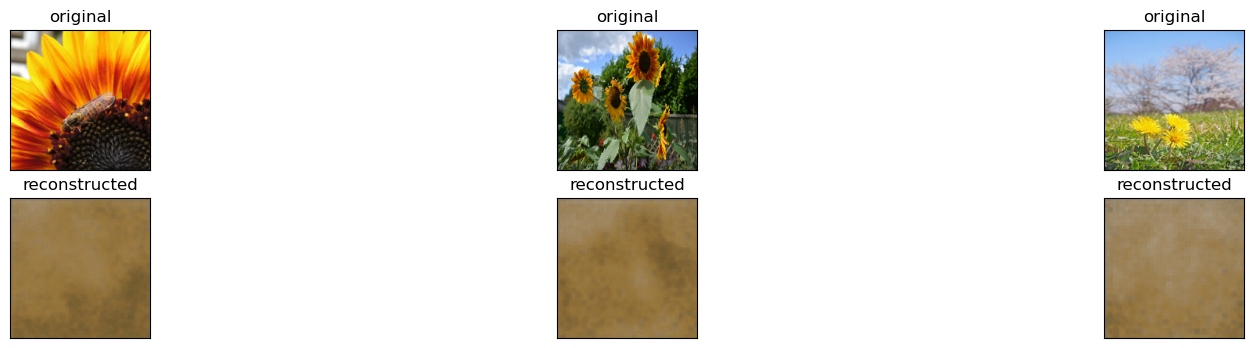

In [34]:
# Comparing the original and decoded examples from the validation set 
# after introducing 20% noise to the intermediate representations

plt.figure(figsize=(20, 4))
for i in range(3):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(val_examples[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_val_noisy_20[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Again, the reconstructed images from the training and validation examples are quite dark, likely due to the low amount of epochs chosen for the training of the autoencoder. Thus, it is not possible to make conclusions regarding the effect of introducing noise to the intermediate representations before decoding them using the autoencoder.

**d) Sample 3 examples from each dataset split, the train and validation set, and introduce 5%, 10% and 20% noise (GaussianNoise Layer) to the image pixels (input level). Run the autoencoder with these inputs and analyze the obtained images.**

Introducing 5% noise to the images in the training and validation examples

In [35]:
# Introducing 5% noise to the images in the training examples

train_noisy_5 = train_examples + 0.05 * tf.random.normal(train_examples.shape)

train_noisy_5 = tf.clip_by_value(train_noisy_5, clip_value_min=0., clip_value_max=1.)

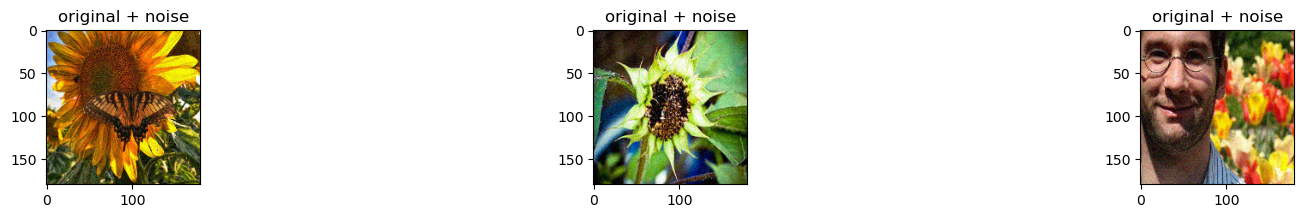

In [36]:
n = 3
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(train_noisy_5[i]))
    plt.gray()
plt.show()

In [37]:
# Introducing 5% noise to the images in the validation examples

val_noisy_5 = val_examples + 0.05 * tf.random.normal(train_examples.shape)

val_noisy_5 = tf.clip_by_value(val_noisy_5, clip_value_min=0., clip_value_max=1.)

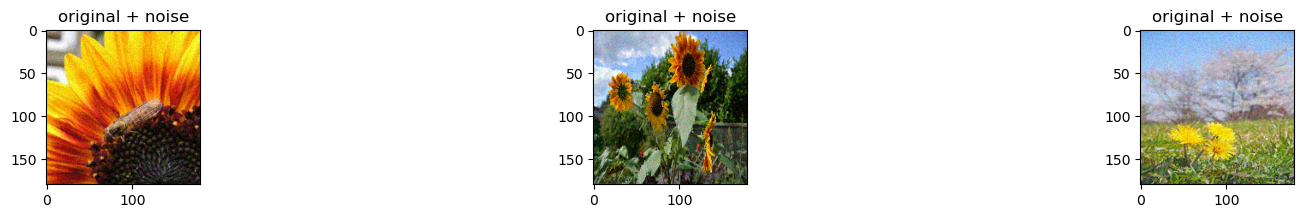

In [38]:
n = 3
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(val_noisy_5[i]))
    plt.gray()
plt.show()

In [39]:
imgs_train_noisy_5 = autoencoder.predict(train_noisy_5)
imgs_val_noisy_5 = autoencoder.predict(val_noisy_5)

1/1 [==============================] - 0s 78ms/step


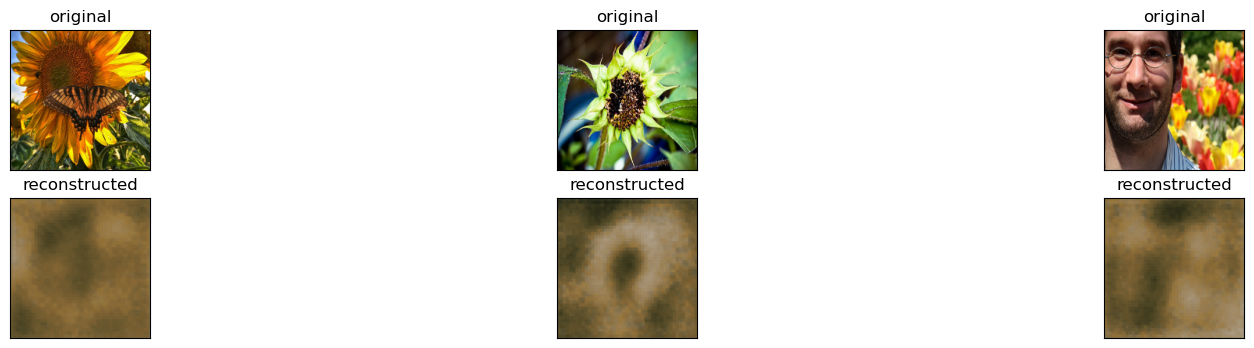

In [40]:
# Comparing the original and decoded examples from the training set 
# after introducing 5% noise to the initial images

plt.figure(figsize=(20, 4))
for i in range(3):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_examples[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs_train_noisy_5[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

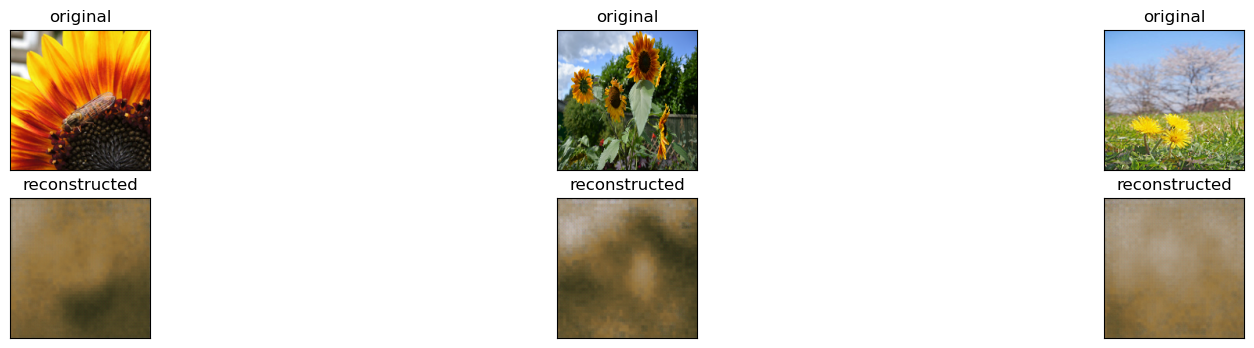

In [41]:
# Comparing the original and decoded examples from the validation set 
# after introducing 5% noise to the initial images

plt.figure(figsize=(20, 4))
for i in range(3):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(val_examples[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs_val_noisy_5[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Introducing 10% noise to the images in the train and validation examples

In [42]:
# Introducing 10% noise to the images in the training examples

train_noisy_10 = train_examples + 0.10 * tf.random.normal(train_examples.shape)

train_noisy_10 = tf.clip_by_value(train_noisy_10, clip_value_min=0., clip_value_max=1.)

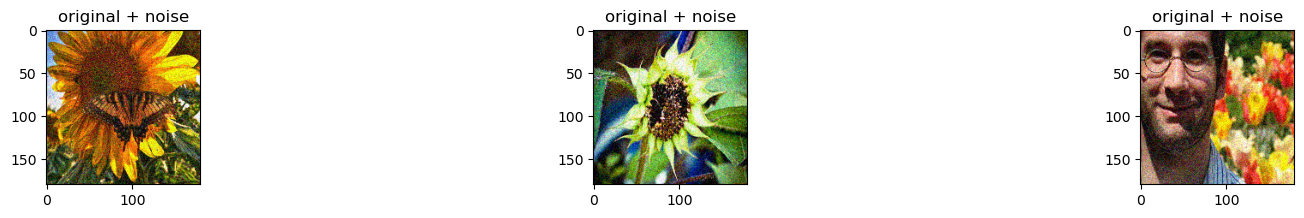

In [43]:
n = 3
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(train_noisy_10[i]))
    plt.gray()
plt.show()

In [44]:
# Introducing 10% noise to the images in the validation examples

val_noisy_10= val_examples + 0.10 * tf.random.normal(train_examples.shape)

val_noisy_10 = tf.clip_by_value(val_noisy_10, clip_value_min=0., clip_value_max=1.)

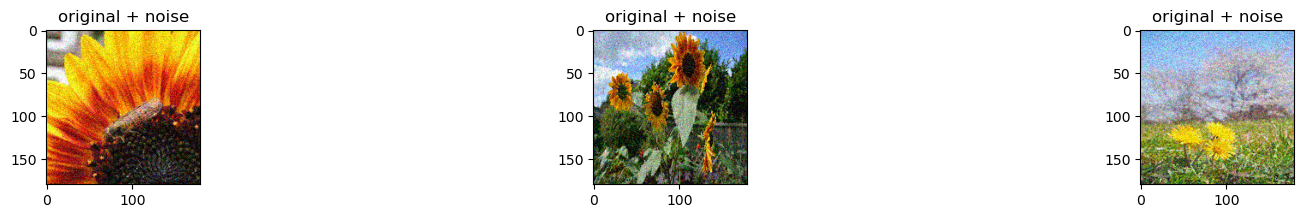

In [45]:
n = 3
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(val_noisy_10[i]))
    plt.gray()
plt.show()

In [46]:
imgs_train_noisy_10 = autoencoder.predict(train_noisy_10)
imgs_val_noisy_10 = autoencoder.predict(val_noisy_10)

1/1 [==============================] - 0s 63ms/step


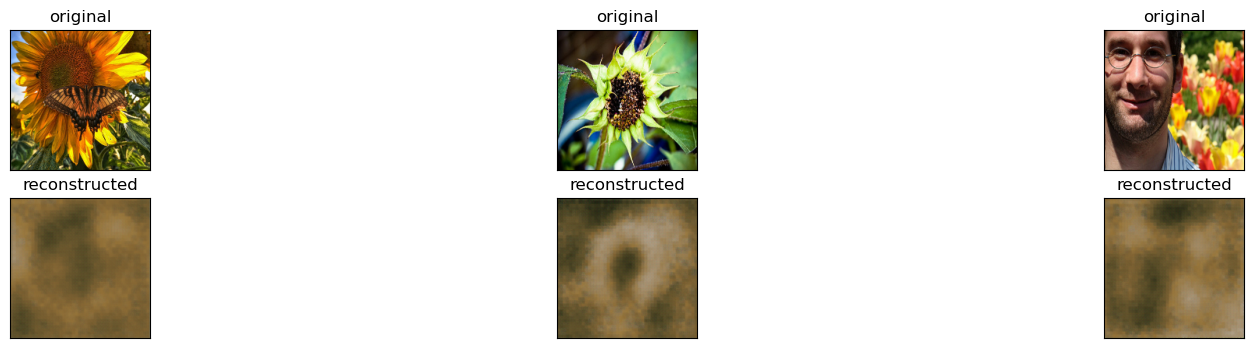

In [47]:
# Comparing the original and decoded examples from the training set 
# after introducing 10% noise to the initial images

plt.figure(figsize=(20, 4))
for i in range(3):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_examples[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs_train_noisy_10[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

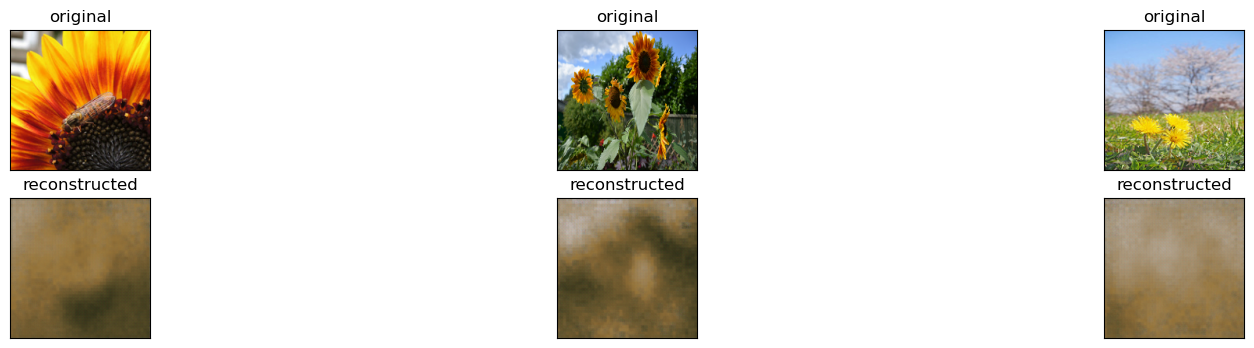

In [48]:
# Comparing the original and decoded examples from the validation set 
# after introducing 10% noise to the initial images

plt.figure(figsize=(20, 4))
for i in range(3):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(val_examples[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs_val_noisy_10[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Introducing 20% noise to the images in the train and validation examples

In [49]:
# Introducing 20% noise to the images in the training examples

train_noisy_20 = train_examples + 0.20 * tf.random.normal(train_examples.shape)

train_noisy_20 = tf.clip_by_value(train_noisy_20, clip_value_min=0., clip_value_max=1.)

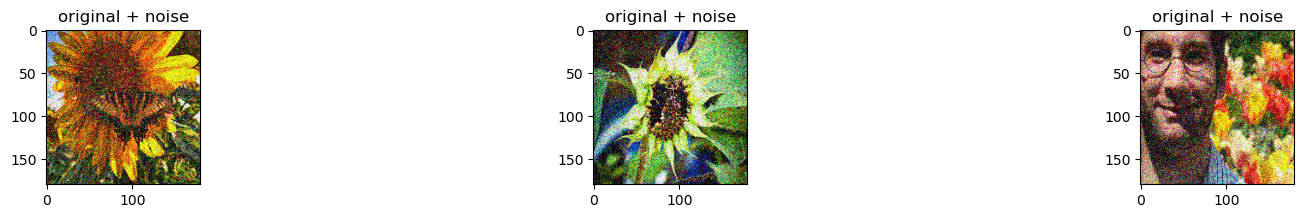

In [50]:
n = 3
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(train_noisy_20[i]))
    plt.gray()
plt.show()

In [51]:
# Introducing 20% noise to the images in the validation examples

val_noisy_20 = val_examples + 0.20 * tf.random.normal(train_examples.shape)

val_noisy_20 = tf.clip_by_value(val_noisy_20, clip_value_min=0., clip_value_max=1.)

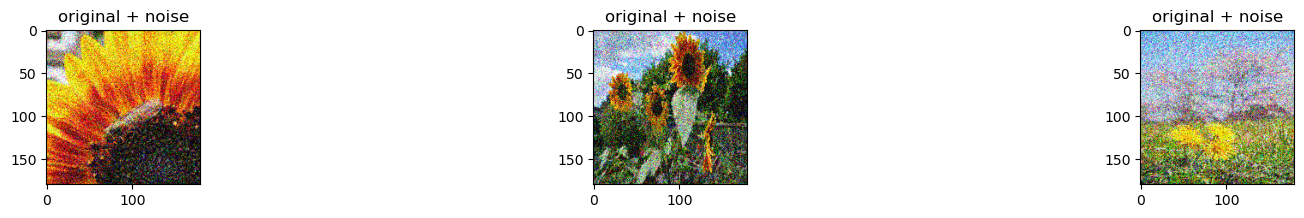

In [52]:
n = 3
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(val_noisy_20[i]))
    plt.gray()
plt.show()

In [53]:
imgs_train_noisy_20 = autoencoder.predict(train_noisy_20)
imgs_val_noisy_20 = autoencoder.predict(val_noisy_20)

1/1 [==============================] - 0s 63ms/step


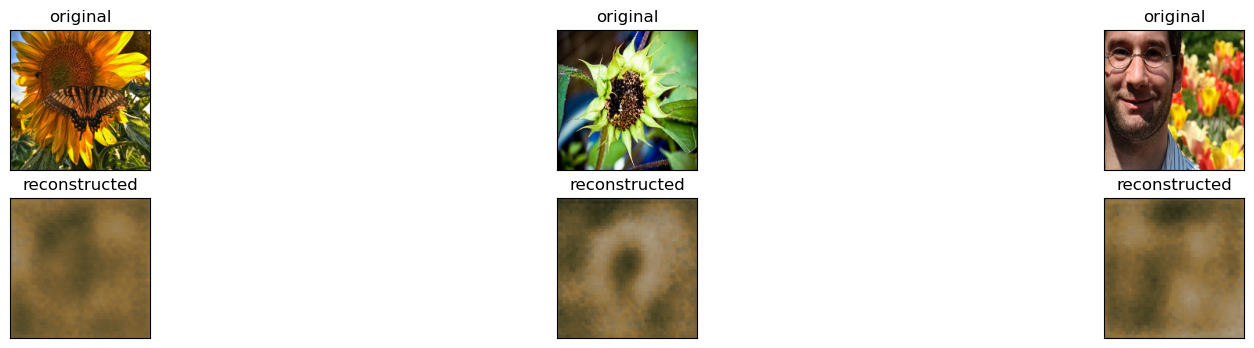

In [54]:
# Comparing the original and decoded examples from the training set 
# after introducing 20% noise to the initial images

plt.figure(figsize=(20, 4))
for i in range(3):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(train_examples[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs_train_noisy_20[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

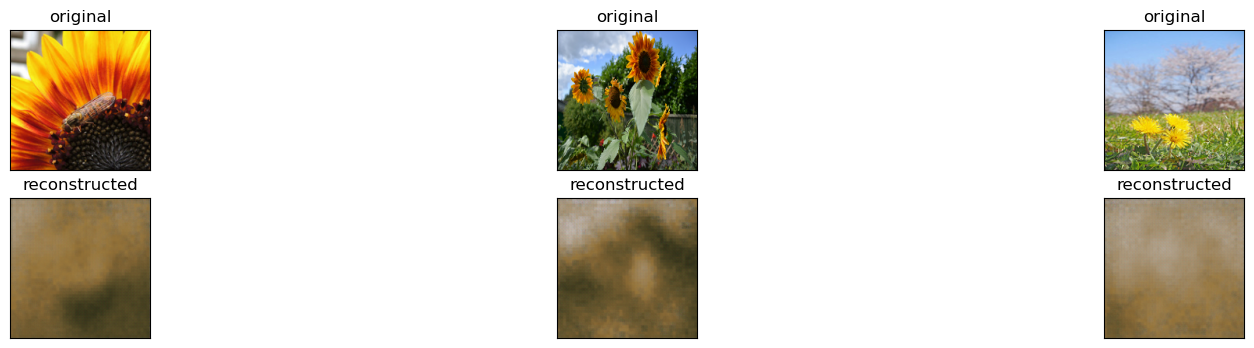

In [55]:
# Comparing the original and decoded examples from the validation set 
# after introducing 20% noise to the initial images

plt.figure(figsize=(20, 4))
for i in range(3):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(val_examples[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(imgs_val_noisy_10[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Again, the reconstructed images from the training and validation examples are quite dark, likely due to the low amount of epochs chosen for the training of the autoencoder. Thus, it is not possible to make conclusions regarding the effect of introducing noise to the image pixels before using the autoencoder.